In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

### Load the Dataset
We begin by importing the dataset using `pandas.read_csv()`.

**Why?**  
This gives us the raw data required to train a predictive model. Viewing the first few rows helps us understand the general structure of the dataset and confirm it loaded successfully.


In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv("carspecs.csv")  # Update with your exact path if needed
df.head()


C:\Users\icyne\AppData\Local\Temp\ipykernel_23640\1889942760.py:4: DtypeWarning: Columns (9,11,12,13,14,15,16,17,19,20,24,27,29,33,43,44,47,49,51,69,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("carspecs.csv")  # Update with your exact path if needed


,id_trim,Make,Modle,Generation,Year_from,Year_to,Series,Trim,Body_type,load_height_mm,...,front_suspension,steering_type,car_class,country_of_origin,number_of_doors,safety_assessment,rating_name,battery_capacity_KW_per_h,electric_range_km,charging_time_h
0,1,AC,ACE,1 generation,1993.0,2000.0,Cabriolet,3.5 MT,Cabriolet,NaN,...,Helical springs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,AC,ACE,1 generation,1993.0,2000.0,Cabriolet,4.6 MT,Cabriolet,NaN,...,Helical springs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,AC,ACE,1 generation,1993.0,2000.0,Cabriolet,4.9 AT,Cabriolet,NaN,...,Helical springs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,AC,ACE,1 generation,1993.0,2000.0,Roadster,2.9 AT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,AC,ACE,1 generation,1993.0,2000.0,Roadster,2.9 MT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Understand the Dataset Structure
Using `df.info()`, we inspect:

- Total number of rows and columns
- Data types of each column (e.g., object, float64, int64)
- Number of non-null (filled) entries

**Why?**  
This helps us identify which columns contain missing data and whether some numeric-looking columns are wrongly typed as strings (`object`). It also allows us to estimate data quality.


In [6]:
# Get a summary of the columns, data types, and non-null values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70823 entries, 0 to 70822
Data columns (total 78 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id_trim                                   70823 non-null  int64  
 1   Make                                      70823 non-null  object 
 2   Modle                                     70823 non-null  object 
 3   Generation                                70819 non-null  object 
 4   Year_from                                 70586 non-null  float64
 5   Year_to                                   70189 non-null  float64
 6   Series                                    70823 non-null  object 
 7   Trim                                      70823 non-null  object 
 8   Body_type                                 52252 non-null  object 
 9   load_height_mm                            3363 non-null   object 
 10  number_of_seats                   

### Preprocessing Function
[please elaborate here]


In [7]:
def preprocess(df):
    df = df.copy()

    # -1. Drop rows with missing engine_hp
    if 'engine_hp' in df.columns:
        df = df.dropna(subset=['engine_hp']).reset_index(drop=True)

    # 0. Extract engine displacement from 'Trim'
    if 'Trim' in df.columns:
        df['engine_displacement'] = df['Trim'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    # 1. Drop irrelevant or weak features
    drop_cols = [
        'id_trim', 'Make', 'Modle', 'Series', 'Trim', 'Generation',
        'steering_type', 'rating_name', 'safety_assessment',
        'battery_capacity_KW_per_h', 'electric_range_km', 'charging_time_h',
        'overhead_camshaft', 'cylinder_bore_and_stroke_cycle_mm', 'bore_stroke_ratio',
        'number_of_seats', 'fuel_grade', 'max_trunk_capacity_l'
    ]
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # 2. Drop columns with more than 40% missing
    missing_threshold = 0.4
    df = df.loc[:, df.isnull().mean() < missing_threshold]

    # 3. Convert numeric strings to floats
    object_cols = df.select_dtypes(include='object').columns
    for col in object_cols:
        try:
            df[col] = df[col].str.replace(',', '').astype(float)
        except:
            continue

    # 4. Remove high-cardinality categorical features (>20 unique values)
    object_cols_post = df.select_dtypes(include='object').columns
    high_cardinality = [col for col in object_cols_post if df[col].nunique() > 20]
    df.drop(columns=high_cardinality, inplace=True)

    # 5. One-hot encode low-cardinality categorical features
    low_cardinality = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() <= 20]
    df = pd.get_dummies(df, columns=low_cardinality, drop_first=True)

    return df


### VISUALISATIONS

In [8]:
df_final = preprocess(df.copy())

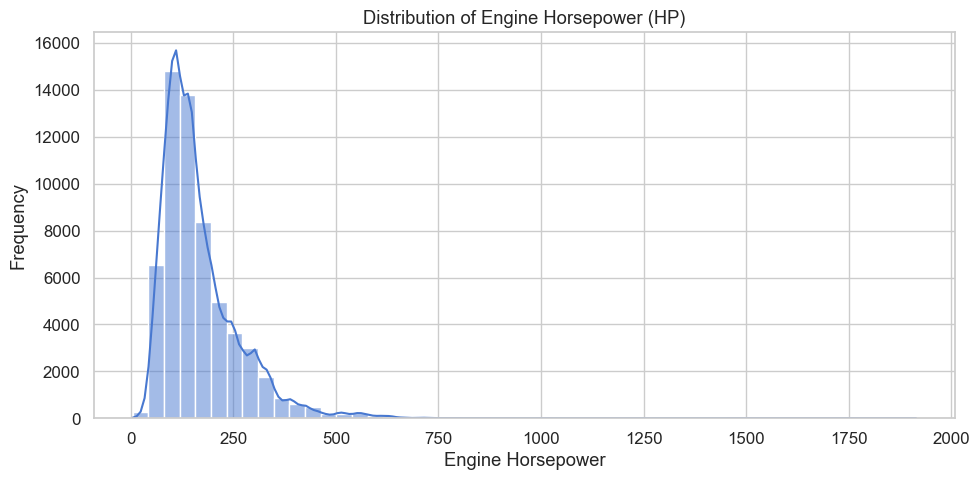

In [9]:
# engine_hp distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

plt.figure(figsize=(10, 5))
sns.histplot(df_final['engine_hp'], bins=50, kde=True)
plt.title('Distribution of Engine Horsepower (HP)')
plt.xlabel('Engine Horsepower')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### CORRELATION 

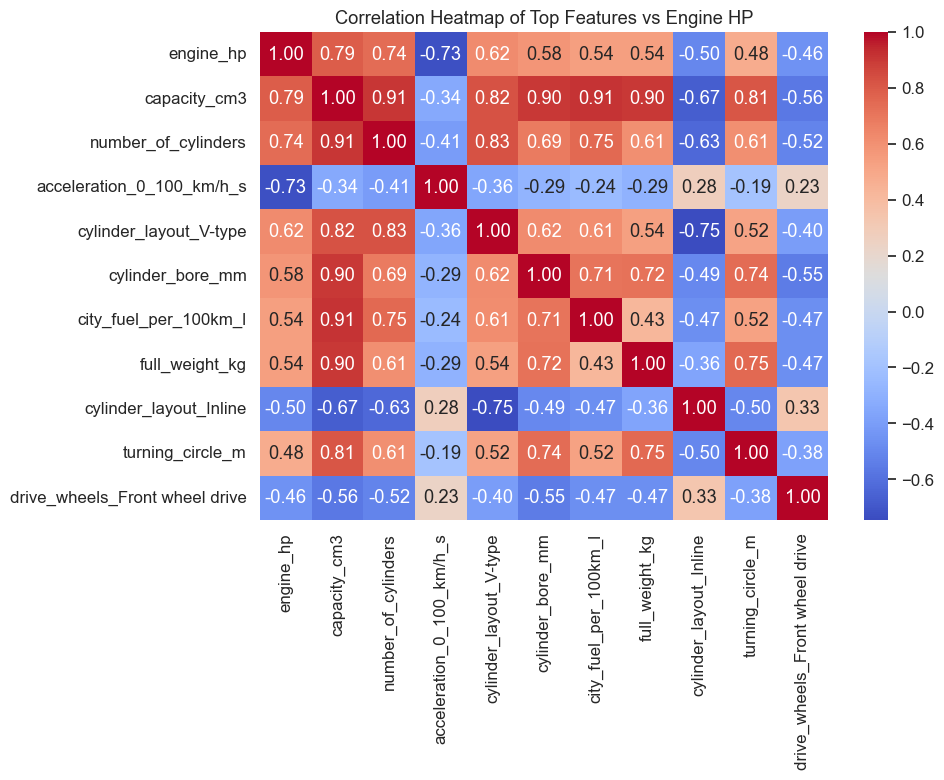

In [10]:
# top 10 features correlated with engine_hp
corr = df_final.corr(numeric_only=True)
top_corr = corr['engine_hp'].abs().sort_values(ascending=False).head(11).index

plt.figure(figsize=(10, 8))
sns.heatmap(df_final[top_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top Features vs Engine HP')
plt.tight_layout()
plt.show()


### Scatter Plot

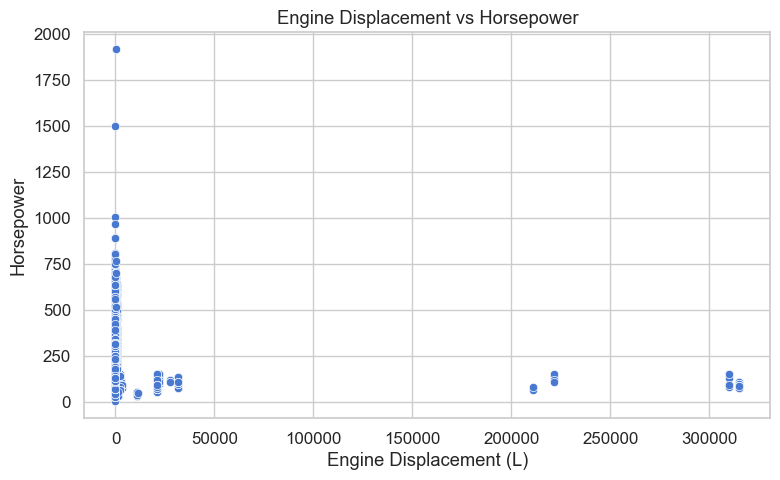

In [11]:
# engine_displacement vs engine_hp
if 'engine_displacement' in df_final.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_final, x='engine_displacement', y='engine_hp')
    plt.title('Engine Displacement vs Horsepower')
    plt.xlabel('Engine Displacement (L)')
    plt.ylabel('Horsepower')
    plt.tight_layout()
    plt.show()


### Box Plot

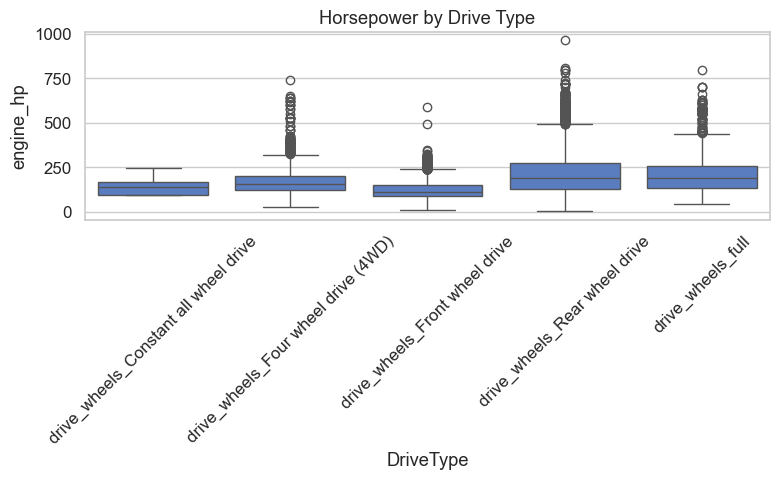

In [12]:
# horsepower by drive_wheels type (based on one-hot columns)
drive_cols = [col for col in df_final.columns if 'drive_wheels' in col]

if drive_cols:
    melted = df_final[['engine_hp'] + drive_cols].melt(id_vars='engine_hp', var_name='DriveType', value_name='Flag')
    melted = melted[melted['Flag'] == 1]

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=melted, x='DriveType', y='engine_hp')
    plt.title('Horsepower by Drive Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Pairplot

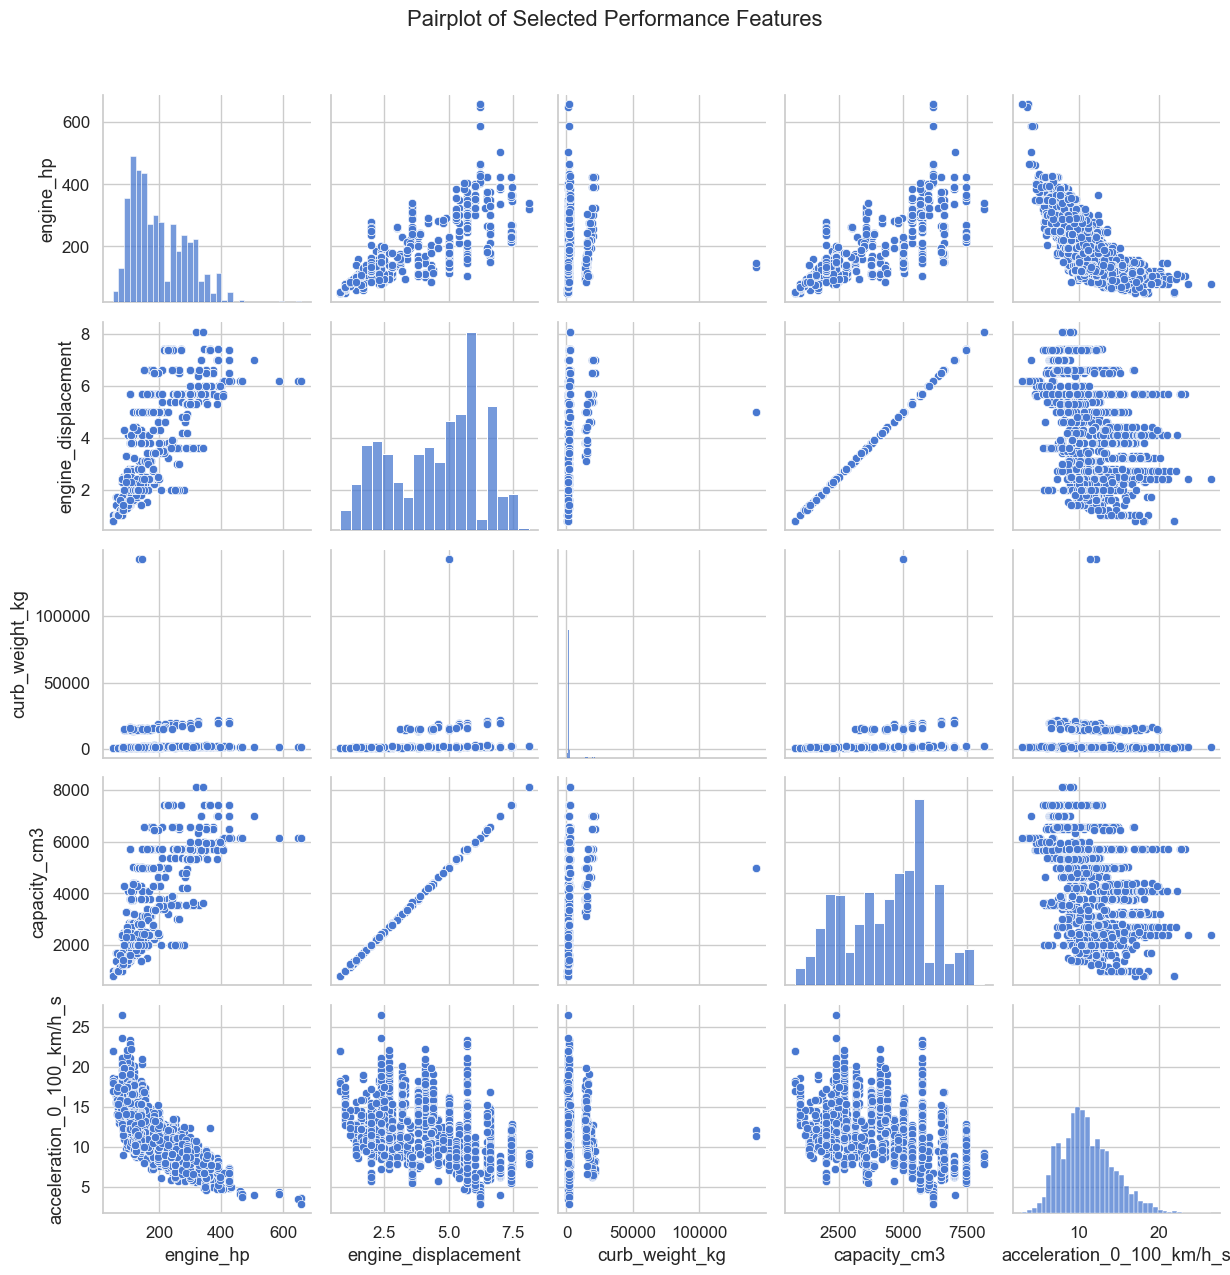

In [13]:
#selected numeric features with histograms on diagonal
selected_vars = ['engine_hp', 'engine_displacement', 'curb_weight_kg', 'capacity_cm3', 'acceleration_0_100_km/h_s']
numeric_vars = []

for col in selected_vars:
    if col in df_final.columns:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
        numeric_vars.append(col)

pairplot_df = df_final[numeric_vars].dropna()

sns.pairplot(pairplot_df, diag_kind='hist')
plt.suptitle("Pairplot of Selected Performance Features", y=1.02)
plt.tight_layout()
plt.show()


### MODEL TRAINING + EVALUATIONS

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd


X = df_final.drop(columns='engine_hp').dropna()
y = df_final.loc[X.index, 'engine_hp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)


               Model        MAE        RMSE        R²
2      Random Forest  10.728684  342.856008  0.963771
0  Linear Regression  17.043172  522.493134  0.944789
1      Decision Tree  10.710526  528.447368  0.944160


### VISUALISATIONS

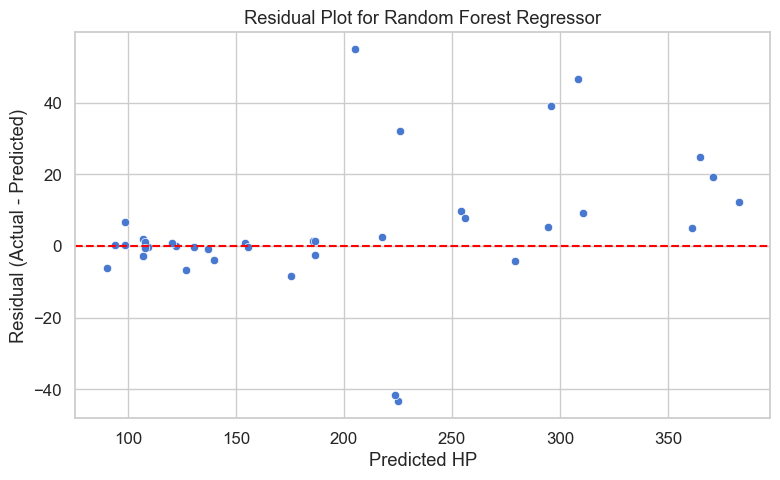

In [15]:
# predictions deviate from actuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted HP")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot for Random Forest Regressor")
plt.tight_layout()
plt.show()


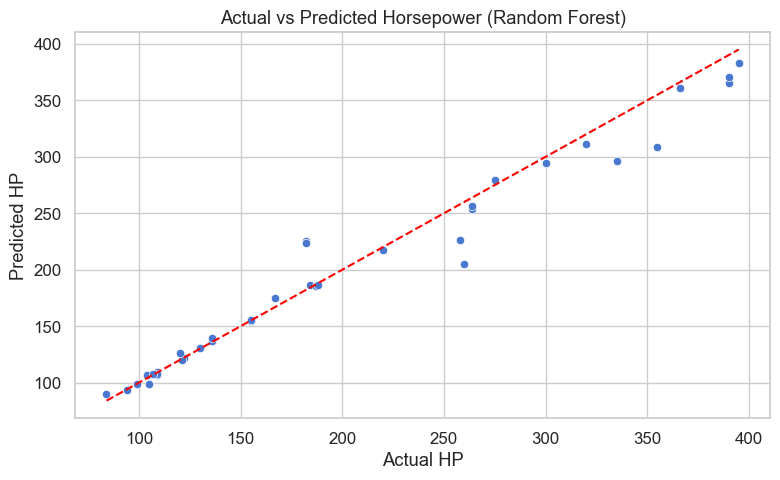

In [16]:
# actual vs predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual HP")
plt.ylabel("Predicted HP")
plt.title("Actual vs Predicted Horsepower (Random Forest)")
plt.tight_layout()
plt.show()


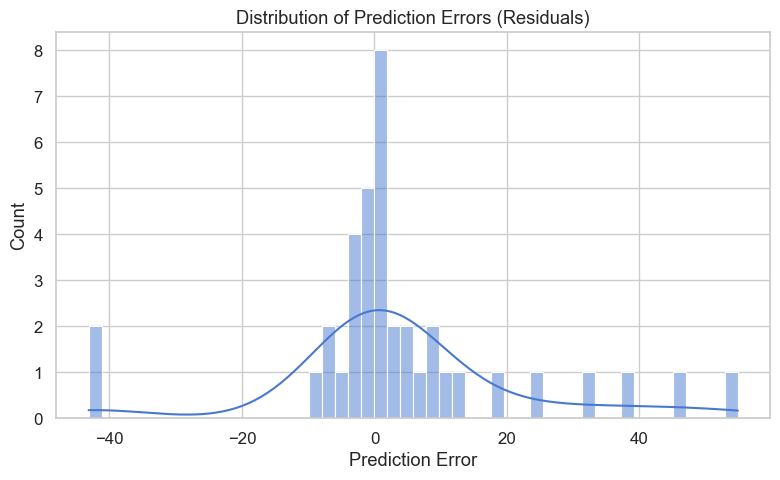

In [17]:
# prediction errors distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Prediction Error")
plt.title("Distribution of Prediction Errors (Residuals)")
plt.tight_layout()
plt.show()


### Hyperparameters tuning

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Define broader parameter grid (no max_depth constraint)
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit search
grid_search.fit(X_train, y_train)

# Best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
cv_rmse = -grid_search.best_score_

# Predictions on both train and test
y_pred_train = best_rf_model.predict(X_train)
y_pred_test = best_rf_model.predict(X_test)

# Train scores
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Test scores
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Results summary
print("✅ Best Parameters:", best_params)
print(f"CV RMSE:       {cv_rmse:.2f}")
print(f"Train RMSE:    {rmse_train:.2f}")
print(f"Test RMSE:     {rmse_test:.2f}")
print(f"Train MAE:     {mae_train:.2f}")
print(f"Test MAE:      {mae_test:.2f}")
print(f"Train R²:      {r2_train:.4f}")
print(f"Test R²:       {r2_test:.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Parameters: {'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
CV RMSE:       21.89
Train RMSE:    7.17
Test RMSE:     22.90
Train MAE:     3.88
Test MAE:      13.74
Train R²:      0.9921
Test R²:       0.9446


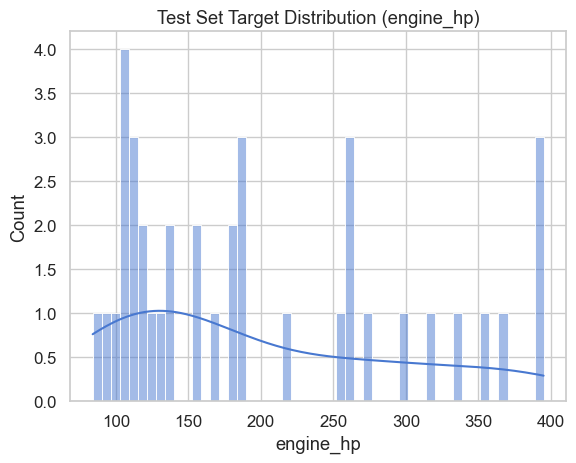

In [ ]:
sns.histplot(y_test, bins=50, kde=True)
plt.title("Test Set Target Distribution (engine_hp)")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

print("Sanity RMSE:", mean_squared_error(y_test, y_pred))


Sanity RMSE: 342.85600789473693
